In [1]:
rm(list=ls())
gc()
setwd("/scratch/AG_Ohler/CheWei/proj_sc/cbpsc")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,574700,30.7,1245252,66.6,853948,45.7
Vcells,1076007,8.3,8388608,64.0,1820945,13.9


In [2]:
as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
options(future.globals.maxSize = 600000 * 1024^2)

[1] 240912980

In [3]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))

In [4]:
suppressMessages(library(dplyr))

In [5]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/tradeseq/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.0.7        ggplot2_3.3.5      SeuratObject_4.0.4 Seurat_4.1.0      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15            colorspace_2.0-3      deldir_1.0-6         
  [4] ellipsis_0.3.2        ggridges_0.5.3        IRdisplay_1.1        
  [7] RcppHNSW_0.3.0       

## Load root atlas downloaded from GEO:GSE152766

In [6]:
## Either seurat version 3 or 4
rc.integrated <- readRDS('../../kallisto-bus/output/Integration/Root_Atlas.rds')
rc.integrated <- readRDS('../../kallisto-bus/output/Integration/Root_Atlas_seu4.rds')

## Developmental stage reannotation

In [11]:
## Load dev stage annotations from Shahan and Hsu et al. 2022
ref <- rc.integrated$time.anno

In [12]:
## Time zone annotation based on Brady et al. 2007
brady <- gsub("-.*$","",rc.integrated$Long.ID.P)

In [13]:
table(brady)

brady
Columella     Elong       Mat      Meri 
       26     52322     29630     28449 

In [14]:
## Merge dev stage annotations from Shahan and Hsu et al. 2022, Li et al. 2016, and Brady et al. 2007)
com3 <- paste0(rc.integrated$time.anno,"_", rc.integrated$timezone.ID.P,"_", brady)

In [15]:
table(com3)

com3
         Distal Columella_Elongation_Columella 
                                             3 
             Distal Columella_Elongation_Elong 
                                           206 
               Distal Columella_Elongation_Mat 
                                          2677 
              Distal Columella_Elongation_Meri 
                                           109 
         Distal Columella_Maturation_Columella 
                                             5 
             Distal Columella_Maturation_Elong 
                                             5 
               Distal Columella_Maturation_Mat 
                                          3149 
              Distal Columella_Maturation_Meri 
                                            26 
                 Distal Columella_Meristem_Mat 
                                           213 
                Distal Columella_Meristem_Meri 
                                           378 
  Distal Lateral Root Cap_Elongatio

In [16]:
## If Shahan&Hsu, Li and Brady annotations are all meristem, then annotated as proliferation domain.  
meri_idx <- as.numeric(which(com3=="Meristem_Meristem_Meri"))
## If Shahan&Hsu and Brady annotations are meristem, but Li annotation is elongation, then annotated as transition domian. 
trans_idx <- as.numeric(which(com3=="Meristem_Elongation_Meri"))
## If Shahan&Hsu annotation is meristem, but Li and Brady annotations are elongation, then annotated as elongation. 
elong_idx <- as.numeric(which(com3=="Meristem_Elongation_Elong"))

In [17]:
ref[which(ref=="Meristem")] = "Unknown"

In [18]:
ref[meri_idx] <- "Proliferation Domain"
ref[trans_idx] <- "Transition Domain"
ref[elong_idx] <- "Elongation"

In [19]:
table(ref)

ref
         Distal Columella   Distal Lateral Root Cap                Elongation 
                     6771                      5818                     46069 
               Maturation      Proliferation Domain        Proximal Columella 
                    20676                      8498                      1764 
Proximal Lateral Root Cap         Transition Domain                   Unknown 
                    12578                      8014                       239 

In [20]:
## Cells that doesn't have annotation after reannotation
unknown_idx <- which(ref=="Unknown")

In [21]:
rc.integrated$tz.ref.anno <- ref

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



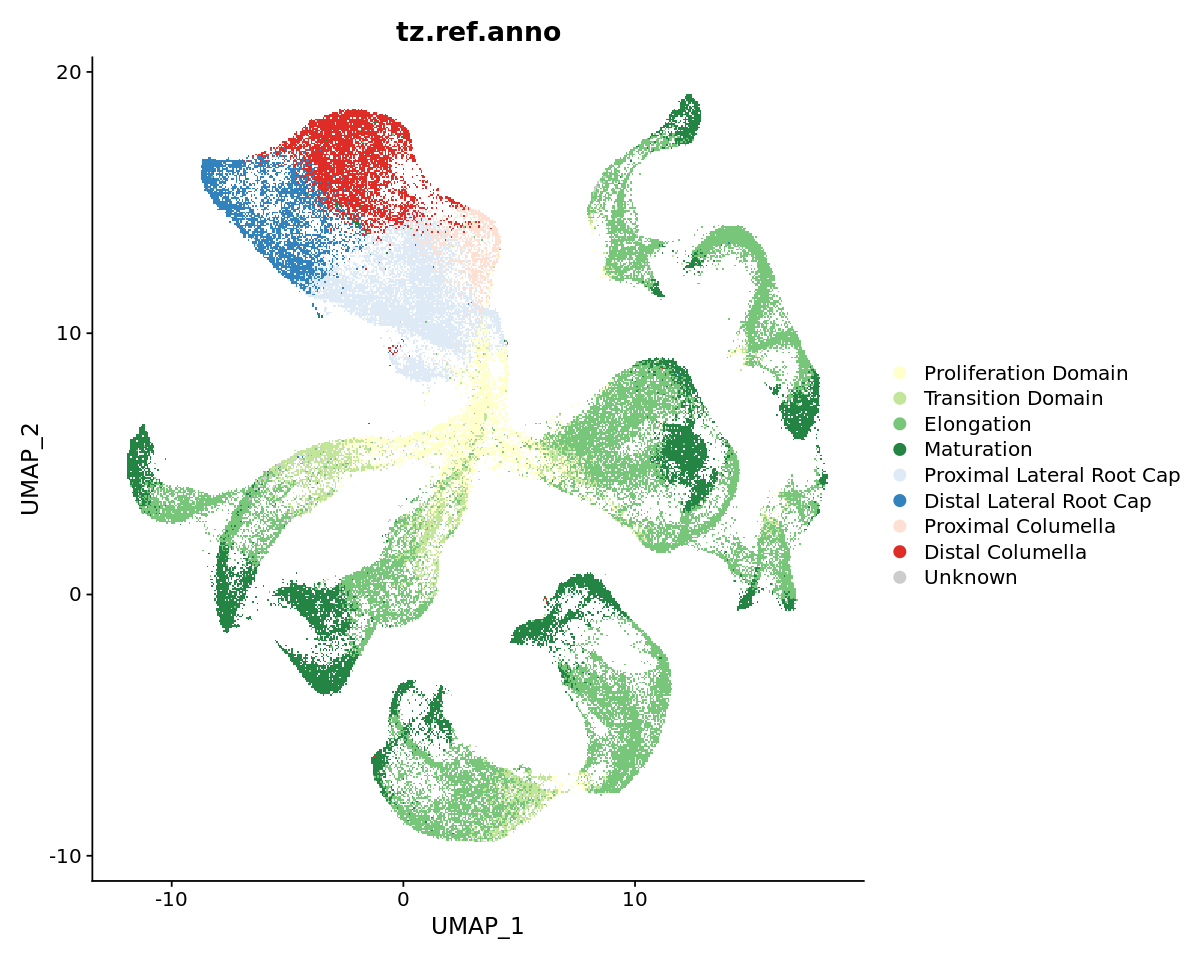

In [22]:
# Plot time
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "tz.ref.anno"
        , order = c("Unknown", "Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#ffffcc','#c2e699','#78c679','#238443', "#deebf7", "#3182bd", '#fee0d2','#de2d26', '#cccccc'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



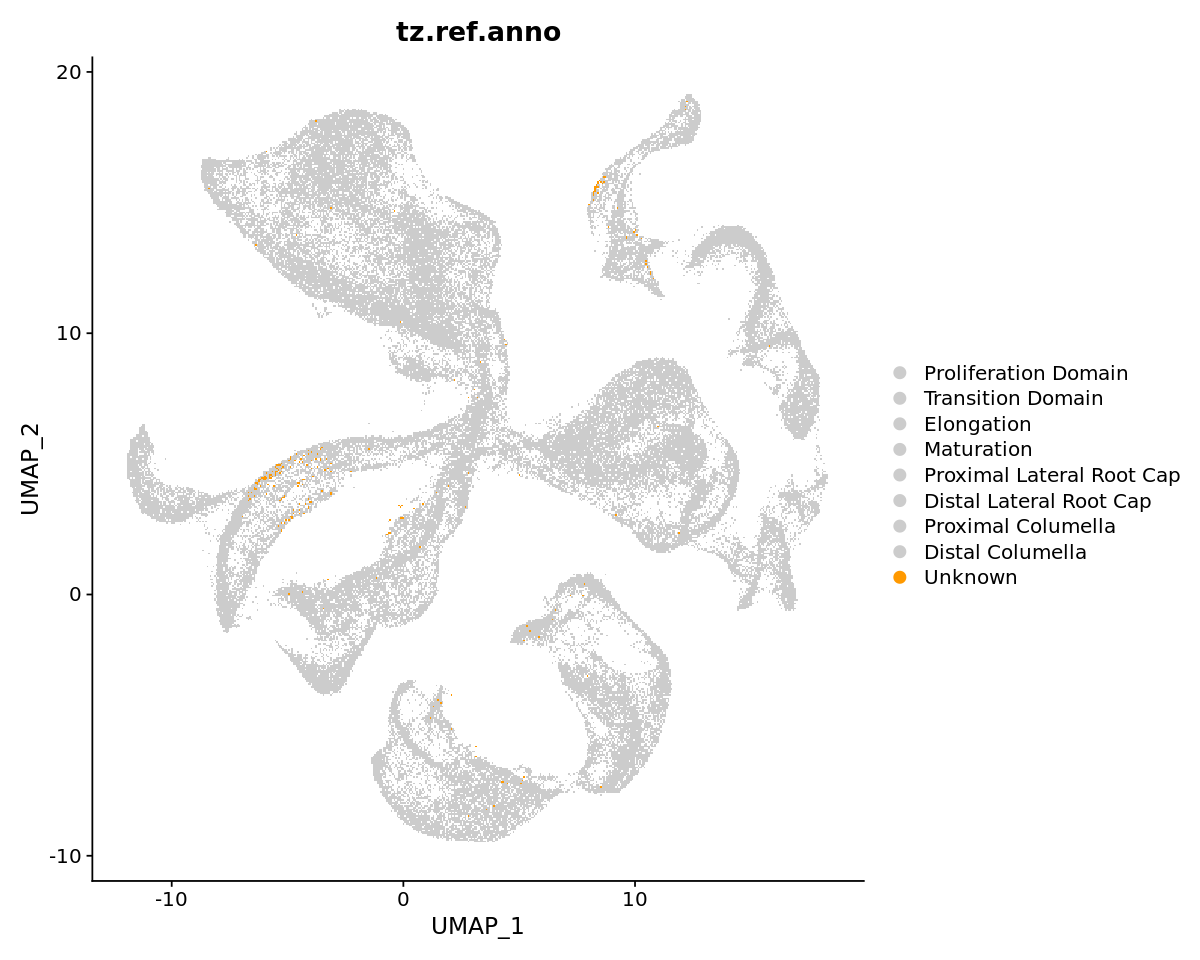

In [23]:
# Plot time
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "tz.ref.anno"
        , order = c("Unknown","Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap", "Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#cccccc','#cccccc','#cccccc','#cccccc','#cccccc','#cccccc','#cccccc','#cccccc','#ff9900'))

## Build reference profiles from annotated cells for annotation of unknown cells

In [25]:
# Extract integrated (batch-corrected) expression matrix
afm <- rc.integrated@assays$integrated@data

# Pool (average) expression values of each grouping
new_ref <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 1:8) {
m <- afm[,which(rc.integrated$tz.ref.anno==as.character(unique(rc.integrated$tz.ref.anno[which(rc.integrated$tz.ref.anno!="Unknown")]))[i])]
new_ref <- cbind(new_ref, rowSums(m)/ncol(m))
}
colnames(new_ref) <- as.character(unique(rc.integrated$tz.ref.anno[which(rc.integrated$tz.ref.anno!="Unknown")]))
gene.var <- apply(new_ref,1,var)

# Select top 200 highly variable genes 
new_ref_sub <- new_ref[names(sort(gene.var,decreasing = TRUE)[1:200]),]

# Merge newly-built reference with atlas

merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

nr <- Reduce(merge.rownames, list(new_ref_sub,afm[,unknown_idx])) 
nr <- as.matrix(nr)

In [26]:
nr <- Reduce(merge.rownames, list(new_ref_sub,afm[,unknown_idx])) 
nr <- as.matrix(nr)

In [27]:
nr <- nr[,-c(3,4,7,8)]

In [30]:
# Correlation-based annotation using newly-built references
nr_label=colnames(new_ref)[-c(3,4,7,8)]
nr_stat <- suppressWarnings(sapply(5:ncol(nr), function(i) sapply(1:4, function(j) cor.test(nr[,i],nr[,j],method = "pearson")[c(3,4)])))
nr_cor <- nr_stat[seq(2,nrow(nr_stat),2),]
nr_pvalue <- nr_stat[seq(1,nrow(nr_stat)-1,2),]                                                                                                        
nr_max <- sapply(1:(ncol(nr)-4), function(i) max(as.numeric(nr_cor[,i])))
nr_ident <- sapply(1:(ncol(nr)-4), function(i) nr_label[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])
nr_maxp <- sapply(1:(ncol(nr)-4), function(i) as.numeric(nr_pvalue[,i])[which(as.numeric(nr_cor[,i])==max(as.numeric(nr_cor[,i])))])                     
names(nr_max) <- nr_ident
anno <- as.character(nr_ident)
#rc.integrated$tz.anno.cor.P <- as.numeric(nr_max)
#rc.integrated$tz.anno.pvalue.P <- as.numeric(nr_maxp)

In [32]:
rc.integrated$tz.anno.P <- rc.integrated$tz.ref.anno
rc.integrated$tz.anno.P[unknown_idx] = anno

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



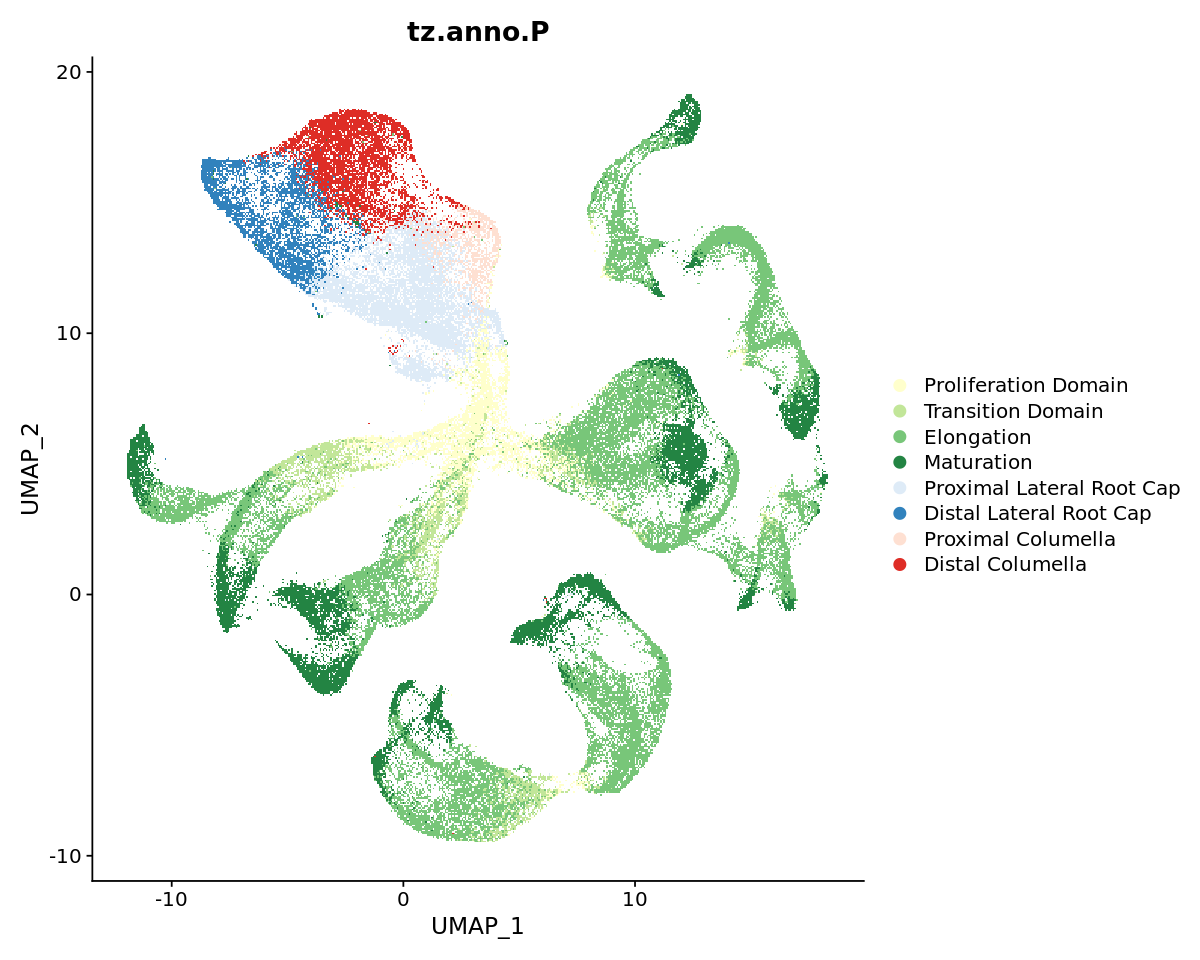

In [33]:
# Plot time
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "tz.anno.P"
        , order = c("Unknown", "Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#ffffcc','#c2e699','#78c679','#238443', "#deebf7", "#3182bd", '#fee0d2','#de2d26', '#cccccc'))

In [34]:
table(paste0(rc.integrated$tz.anno.P,"_",rc.integrated$celltype.anno.crude))


                Distal Columella_Columella 
                                      6771 
  Distal Lateral Root Cap_Lateral Root Cap 
                                      5818 
                   Elongation_Atrichoblast 
                                      4669 
                         Elongation_Cortex 
                                      6034 
                     Elongation_Endodermis 
                                      7101 
                      Elongation_Pericycle 
                                     11112 
                         Elongation_Phloem 
                                      2953 
                     Elongation_Procambium 
                                      6968 
                    Elongation_Trichoblast 
                                      3794 
                          Elongation_Xylem 
                                      3467 
                   Maturation_Atrichoblast 
                                      3381 
                         Matura

In [35]:
rc.integrated$time.anno.Li <- as.character(rc.integrated$tz.anno.P)

## Assign QC cells to proliferation domain

In [36]:
idx <- as.numeric(which(rc.integrated$celltype.anno == "Quiescent Center"))

In [37]:
rc.integrated$time.anno.Li[idx] <- "Proliferation Domain"

In [38]:
table(rc.integrated$time.anno.Li)


         Distal Columella   Distal Lateral Root Cap                Elongation 
                     6771                      5818                     46098 
               Maturation      Proliferation Domain        Proximal Columella 
                    20707                      8538                      1764 
Proximal Lateral Root Cap         Transition Domain 
                    12578                      8153 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



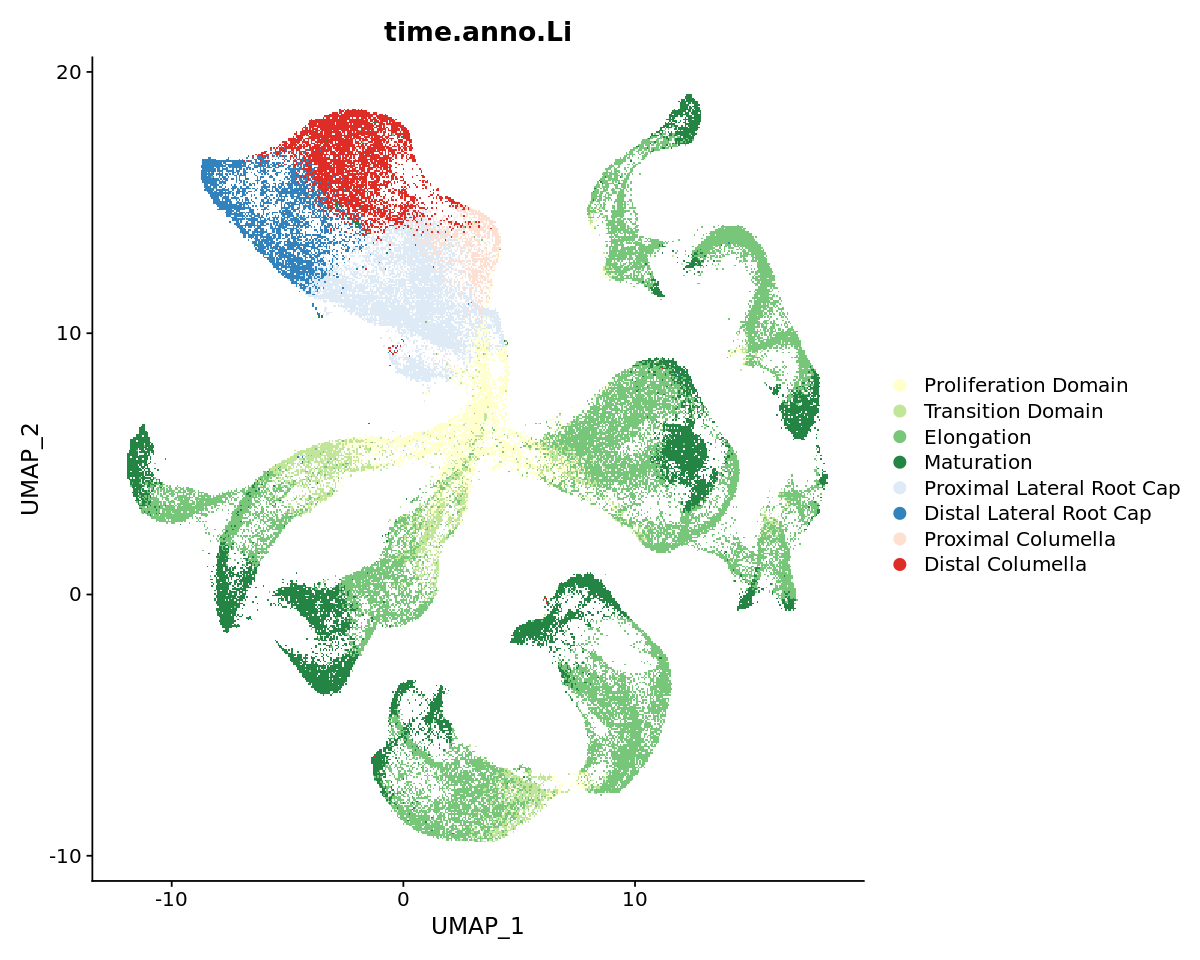

In [ ]:
# Plot time
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno.Li"
        , order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#ffffcc','#c2e699','#78c679','#238443', "#deebf7", "#3182bd", '#fee0d2','#de2d26'))